In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import os

In [2]:
# importing data
bankdata = pd.read_csv("customer_bank_marketing_data.csv")
bankdata

,age,job,marital,education,default,balance,housing,loan,deposit_num
0,59,administrative,married,secondary,no,2343,yes,no,1
1,56,administrative,married,secondary,no,45,no,no,1
2,41,technician,married,secondary,no,1270,yes,no,1
3,55,services,married,secondary,no,2476,yes,no,1
4,54,administrative,married,tertiary,no,184,no,no,1
...,...,...,...,...,...,...,...,...,...
45202,59,management,married,tertiary,no,138,yes,yes,0
45203,37,management,married,tertiary,no,1428,no,no,0
45204,34,blue-collar,single,secondary,no,1475,yes,no,0
45205,57,blue-collar,married,secondary,no,668,no,no,0


## One Hot Encoding

In [3]:
# separate categorical columns out
cols = bankdata.columns
num_cols = bankdata._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))

for var in cat_cols:
    bankdata = pd.concat([bankdata.drop(var, axis=1), pd.get_dummies(bankdata[var], prefix=var, prefix_sep='_', drop_first=True, dummy_na=False, dtype=int)], axis=1)

# drop the unknown column as it does not help with targeting customer
bankdata.drop(columns = ['job_unknown'], inplace = True)
bankdata.drop(columns = ['education_unknown'], inplace = True)    
bankdata

,age,balance,deposit_num,loan_yes,marital_married,marital_single,housing_yes,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,education_secondary,education_tertiary,default_yes
0,59,2343,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,56,45,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,41,1270,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0
3,55,2476,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
4,54,184,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45202,59,138,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
45203,37,1428,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
45204,34,1475,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0
45205,57,668,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [4]:
print("number of no deposit: ", bankdata[bankdata['deposit_num'] == 0].shape[0])
print("number of deposit: ", bankdata[bankdata['deposit_num'] == 1].shape[0])

number of no deposit:  39918
number of deposit:  5289


As we can see, there is an imbalanced between the number of positive and negative results of depopsit. We need to address this imbalance before proceeding. 

In [5]:
# address class imbalance by oversampling the minority class in the dataset, 
# ensuring that both classes are represented equally in the resampled data.

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

smote = SMOTE(sampling_strategy='auto', random_state=42)
#undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

pipeline = Pipeline([
    ('smote', smote),
    #('undersampler', undersampler)
])

x = bankdata.drop('deposit_num', axis = 1)
y = bankdata['deposit_num']

# Print class distribution before resampling
print("Class distribution before resampling:")
print(y.value_counts())

x_resampled, y_resampled = pipeline.fit_resample(x, y)

# Print class distribution after resampling
print("Class distribution after resampling:")
print(y_resampled.value_counts())

print("Number of rows after undersampling:", len(x_resampled))


Class distribution before resampling:
deposit_num
0    39918
1     5289
Name: count, dtype: int64
Class distribution after resampling:
deposit_num
1    39918
0    39918
Name: count, dtype: int64
Number of rows after undersampling: 79836


# Machine Learning Model

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm
from sklearn.metrics import accuracy_score

### All Features with Logistic Regression 

In [7]:
x_train,x_test,y_train,y_test = train_test_split(x_resampled,y_resampled,test_size = 0.3, random_state = 40)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

lr = LogisticRegression(random_state = 40, max_iter=1000)
lr.fit(x_train_scaled,y_train)
y_pred = lr.predict(x_test_scaled)

In [8]:
print('Report:\n',classification_report(y_test, y_pred))
print("F1 Score:",f1_score(y_pred,y_test))
print('confusion Matrix:\n',confusion_matrix(y_pred,y_test))
print("Acurracy :::>",accuracy_score(y_pred,y_test))

Report:
               precision    recall  f1-score   support

           0       0.79      0.84      0.81     11957
           1       0.83      0.78      0.80     11994

    accuracy                           0.81     23951
   macro avg       0.81      0.81      0.81     23951
weighted avg       0.81      0.81      0.81     23951

F1 Score: 0.800429553264605
confusion Matrix:
 [[9988 2677]
 [1969 9317]]
Acurracy :::> 0.8060206254436141


### Using RFE

In [9]:
# Using Rfe
from sklearn.feature_selection import RFE
rfe = RFE(estimator=lr, n_features_to_select=15)
rfe.fit(x_train,y_train)

print(x_train.columns[rfe.support_])
cols = x_train.columns[rfe.support_]
lr.fit(x_train[cols],y_train)
y_pred2 = lr.predict(x_test[cols])

Index(['loan_yes', 'marital_married', 'marital_single', 'housing_yes',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'default_yes'],
      dtype='object')


Rfe has determined the above 15 features as the most important features in a dataset through an iterative process of feature elimination.

In [10]:
def logReg_result():
    print('Report:\n',classification_report(y_test, y_pred2))
    print("F1 Score:",f1_score(y_pred2,y_test))
    print('AUC score:',roc_auc_score(y_test,y_pred2))
    print('confusion Matrix:\n',confusion_matrix(y_pred2,y_test))
    print('cross validation:\n',cross_val_score(lr, x, y, cv=5))
    print("Acurracy :::>",accuracy_score(y_pred2,y_test))
    
logReg_result()

Report:
               precision    recall  f1-score   support

           0       0.78      0.83      0.80     11957
           1       0.81      0.77      0.79     11994

    accuracy                           0.80     23951
   macro avg       0.80      0.80      0.80     23951
weighted avg       0.80      0.80      0.80     23951

F1 Score: 0.7893425010743447
AUC score: 0.7953779585563738
confusion Matrix:
 [[9865 2810]
 [2092 9184]]
cross validation:
 [0.8827693  0.88287989 0.88297755 0.88297755 0.88275633]
Acurracy :::> 0.7953321364452424


Precision: The proportion of true positive predictions out of all positive predictions.

Recall: The proportion of true positive predictions out of all actual positives.

F1-score: The harmonic mean of precision and recall. It provides a balance between precision and recall. 

Support: The number of actual occurrences of each class in the test set. 

AUC: shows how well the classifier distinguishes positive and negative classes

The key difference observed after applying RFE is a slight decrease in the overall accuracy of the model. This decrease in accuracy may be attributed to the removal of some features deemed less important by RFE, resulting in a slightly less complex model.
However, despite the decrease in overall accuracy, the precision, recall, and F1-score for both classes remained high, indicating that the model's ability to correctly classify instances of both classes was largely unaffected by the feature selection process.

### Feature Importance

In [11]:
from sklearn.feature_selection import SelectFromModel
smf = SelectFromModel(lr)
smf.fit(x_train,y_train)
features = smf.get_support()
feature_name = x_train.columns[features]
feature_name

Index(['job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_self-employed', 'job_services', 'job_technician',
       'job_unemployed'],
      dtype='object')

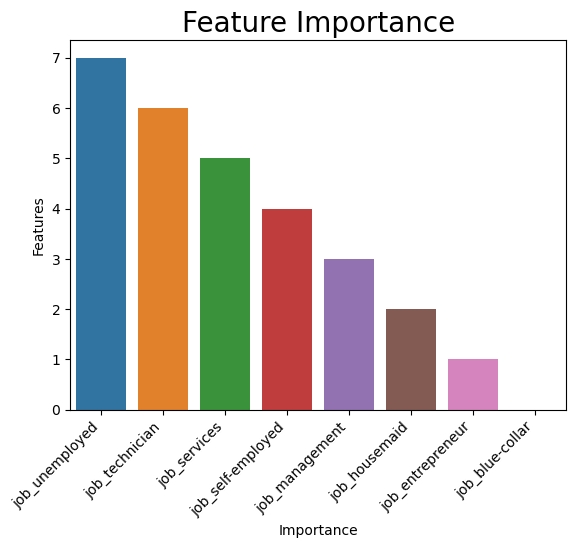

In [12]:
importances=feature_name
feature_importances = pd.Series(importances).sort_values(ascending=False)
ax = sb.barplot(x=feature_importances[0:10], y=feature_importances.index[0:10])

# Rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

# Set plot title and labels
plt.title('Feature Importance', size=20)
plt.ylabel("Features")
plt.xlabel("Importance")
plt.show()

From the above result, the top 3 most important features of a customer seems to be the one with occupation of unemployment, technician or in the services sector. 

## Random Forest Classifier

In [13]:
from sklearn.ensemble import RandomForestClassifier

x_train,x_test,y_train,y_test = train_test_split(x_resampled,y_resampled,test_size = 0.3,random_state=40)

rfc = RandomForestClassifier(n_estimators=50,max_depth=5, random_state=101,max_leaf_nodes=50)
rfc.fit(x_train,y_train)

y_pred1 = rfc.predict(x_test)

n_estimators: The number of trees in the forest.

max_depth: The maximum depth of the trees.

random_state: The seed used by the random number generator for randomization and reproducibility.

max_leaf_nodes: The maximum number of leaf nodes in each tree.

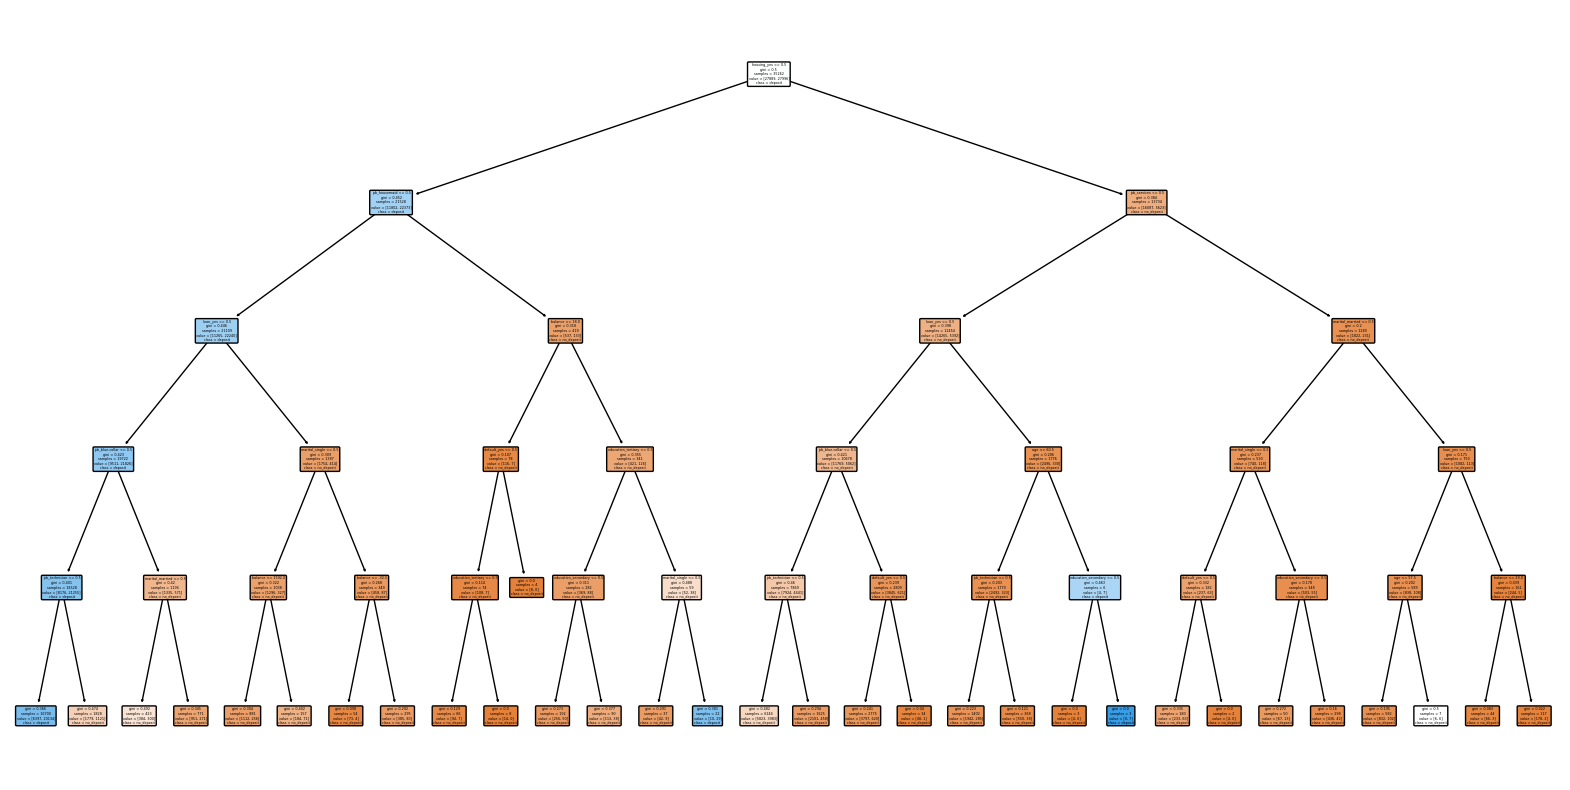

In [14]:
from sklearn.tree import plot_tree

estimator = rfc.estimators_[5]

# Convert the Index object to a list
feature_names_list = list(x_train.columns)

# Plot the decision tree
plt.figure(figsize=(20,10))  # Adjust the figure size as needed
plot_tree(estimator, 
          feature_names=feature_names_list,  # Use the list of feature names
          class_names=['no_deposit', 'deposit'],  # Specify class names
          filled=True, rounded=True)
plt.show()

In [15]:
def RF_result():
    print('Report:\n',classification_report(y_test, y_pred1))
    print("F1 Score:",f1_score(y_pred1,y_test))
    print('confusion Matrix:\n',confusion_matrix(y_pred1,y_test))
    print('cross validation:',cross_val_score(rfc, x, y, cv=5))
    print('AUC score:',roc_auc_score(y_test,y_pred))
    print("Acurracy :::>",accuracy_score(y_pred,y_test))
    
RF_result()

Report:
               precision    recall  f1-score   support

           0       0.78      0.74      0.76     11957
           1       0.75      0.79      0.77     11994

    accuracy                           0.77     23951
   macro avg       0.77      0.77      0.77     23951
weighted avg       0.77      0.77      0.77     23951

F1 Score: 0.7719969084326567
confusion Matrix:
 [[8857 2505]
 [3100 9489]]
cross validation: [0.88299049 0.88299049 0.88297755 0.88297755 0.84891052]
AUC score: 0.8060658280688949
Acurracy :::> 0.8060206254436141


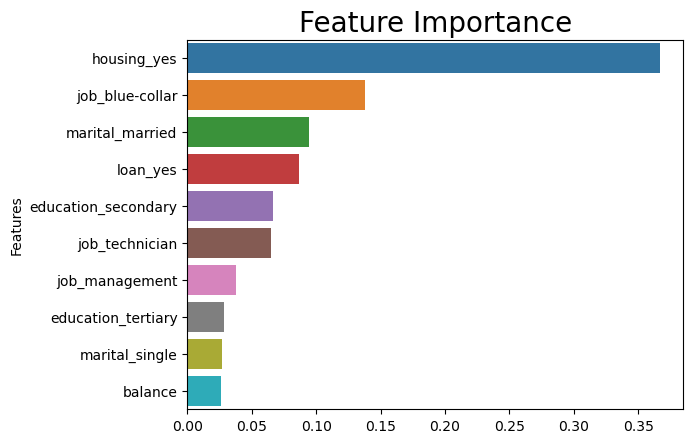

In [16]:
importances=rfc.feature_importances_
feature_importances=pd.Series(importances, index=x_train.columns).sort_values(ascending=False)
sb.barplot(x=feature_importances[0:10], y=feature_importances.index[0:10])
plt.title('Feature Importance',size=20)
plt.ylabel("Features")
plt.show()

From the result above, it suggests that some of the most important features of a customer seems to be one with housing loan, a blue-collar job, with personal loan and married. 

## Comparison

In [17]:
print("############### Random Forest Result: ###############\n")
RF_result()
print('\n\n############# Logistic Regression Result: ############\n')
logReg_result()

############### Random Forest Result: ###############

Report:
               precision    recall  f1-score   support

           0       0.78      0.74      0.76     11957
           1       0.75      0.79      0.77     11994

    accuracy                           0.77     23951
   macro avg       0.77      0.77      0.77     23951
weighted avg       0.77      0.77      0.77     23951

F1 Score: 0.7719969084326567
confusion Matrix:
 [[8857 2505]
 [3100 9489]]
cross validation: [0.88299049 0.88299049 0.88297755 0.88297755 0.84891052]
AUC score: 0.8060658280688949
Acurracy :::> 0.8060206254436141


############# Logistic Regression Result: ############

Report:
               precision    recall  f1-score   support

           0       0.78      0.83      0.80     11957
           1       0.81      0.77      0.79     11994

    accuracy                           0.80     23951
   macro avg       0.80      0.80      0.80     23951
weighted avg       0.80      0.80      0.80     23951

F1

We see that the Random Forest has Perfomed slightly better in comparision to Logistic Regression.

## Conclusion from both model

Both models achieved reasonably good performance metrics, with F1-scores around 0.77-0.79 and Random Forest with higher accuracies than Logistic Regression

The AUC score of the Random Forest model (0.806) is higher compared to Logistic Regression (0.795), indicating that Random Forest performs better in terms of ranking the predictions.

Cross-validation scores are consistent across both models, suggesting that the performance metrics are stable and not overfitted to the training data.

Based on the type of problem we are facing, Random Forest is preferred. 